# State Independent Bayesian Optimization: 
- Sina Dabiri 


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('dark_background')
import GPy
from sklearn.metrics import mean_squared_error

In [2]:
path = "Mark_4sec_CA3PSD_ISO_freqamp_020619.csv"

In [3]:
class state_dr_gp:
    '''
    A class to run a Gaussian Process model. 
    
    
    '''
    def gp_model(self, csv_path):
        # Import datasets as pandas
        CA1_df = pd.read_csv(path)

        # Get frequency and amplitudes
        U1 = CA1_df.iloc[:,  0:2]
        # Get the coordinate of pre stimulation gamma 
        X0_coords = np.arange(33,52)

        # sum of pre stimulation gamma
        data = np.sum(CA1_df.iloc[:, X0_coords], axis=1)
        X0_psd = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
        X0_psd = X0_psd*1e10 # Need values >0 for GP model
        N_trials = np.size(X0_psd, axis=0)
        lower_bound = np.min(U1, axis=0)
        upper_bound = np.max(U1, axis=0)
        # sum of post stimulation gamma         
        X1_coords = np.arange(133,152)
        X1 = np.sum(CA1_df.iloc[:, X1_coords],axis=1)
        X1 = np.array(X1)
        X1 =X1[:, np.newaxis] # reshape
        X1 = X1*1e10 # bring to >0 range        

        return X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials;
    
    def apply_data_mask(self, U1_X0, X1, n_used_samples):
        # n_used_samples = 100; 
        scale = .1
        f_thresh = 25; g_thresh = 3
        U1_X0_sel = U1_X0[1:n_used_samples]
        X1_sel = np.squeeze(X1[1:n_used_samples])

        X1_thresh = np.squeeze(np.array(U1_X0_sel['sum_preStim_gamma'] > g_thresh, dtype = bool))
        # U1_thresh = U1_X0_sel['Stim_1'] > f_thresh
        sc= 1+scale*np.sin(np.array(U1_X0_sel.Stim_1)*0.1)*(1/(1+np.exp(-(np.array(U1_X0_sel['sum_preStim_gamma'])-2.5))))

        #X1_sel[X1_thresh] = np.multiply(X1_sel[X1_thresh],sc)
        X1_sel = np.multiply(X1_sel,sc)
        #display( np.multiply(X1_sel[X1_thresh],sc))
        X1_sel = X1_sel.reshape(-1,1)
    
        return U1_X0_sel, X1_sel;

    # initialize_data_dr_sim() function
    def initialize_data_dr_sim(self, U1, X0_psd, X1, kernel, slice_dim, ylabel):
       
        # input_data
        # U1_X0 = U1.join(X0_psd)
        
        # create simple GP model
        m = GPy.models.GPRegression(U1,X1,kernel)
        figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
                      title="before Optimization");
        display(canvas);
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax);
        
        # optimize and plot
        m.optimize(messages=True,max_f_eval = 1000);
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
        display(canvas)
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax)
        
        # Plotting slices of the model at amplitudes of 0, 10, and 50
        slices = [0, 10, 50]
        figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

        for i, y in zip(range(3), slices):
            print((1,y));

            canvas = m.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                            xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

        display(canvas);
            
        return U1, X1, m; 
    
    
    #Sample Function
    def sample(self,testX, m):

        posteriorTestY = np.empty((100))
        simY  = np.empty((100))
        simMse = np.empty((100))

        state_est = m.posterior_samples_f(testX, full_cov=True, size=1)[:,0,0]
        simY, simMse = m.predict(testX)

        # print("mean is: \n",simY[0],"\n\n Variance is: \n", simMse[0])
        # # posteriorTestY
        # print(np.shape(posteriorTestY),'\n',posteriorTestY[0:10])
        # print(np.shape(simY),'\n', np.shape(simMse))

        return state_est, simY, simMse;
    
    # Acquisition Function
    def acquisition_function(self, simY, simMse, nu, t):
        # Upper Confidence Bound implementation
        #  if d=2 and delta=2
        tau_t = 2*np.log(t**2*(np.pi)**2/6)
        
        ucb = simY+(np.sqrt(nu*tau_t))*simMse
        
        return ucb
    
    # The next step training and bayes_opt_update_state() function
    def bayes_opt_update_state(self, U1, X1, ker_BaO):
         # create simple GP model
        trained_model_BaO = GPy.models.GPRegression(U1,X1,ker_BaO);
        trained_model_BaO.optimize(messages=False,max_f_eval = 1000);
        
        return trained_model_BaO
    
    
    def transition_state(self, U1, X0_psd, state_est, testX):
        state_data_dr = X0_psd
        current_state = np.append(X0_psd, state_est[:,0:1], axis=0)
#         testX_shape_row, testX_shape_col = np.shape(testX)
        
#         current_state = np.empty(())
        
        return current_state
        
    

In [4]:
model = state_dr_gp()

In [5]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials = model.gp_model(path)

In [6]:
n_all_samples = np.shape(U1)[0]
n_used_samples = 100
n_burn_in = 20
n_samples= 150
n_acquisition = 100
n_parameters_optimizing = 2 # here we are optimizing freq. and amp.
n_all_parameters = 3 # freq amp and preStimGamma
n_exp_runs = 30
n_samples_to_remember = 20
print(n_used_samples)
print(np.shape(X0_psd.iloc[0:n_used_samples]))
print(np.shape(U1.iloc[0:n_used_samples]), np.shape(X1[0:n_used_samples,:]))
# print(U1)
# print(X1)

100
(100, 1)
(100, 2) (100, 1)


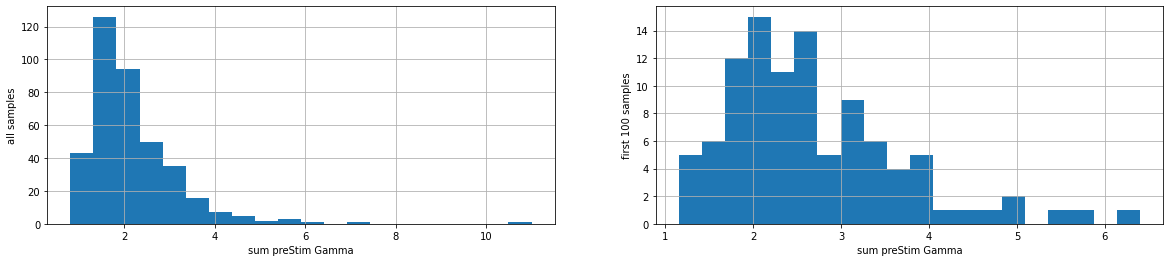

In [7]:
# histogram of raw PSD of preStim gamma
fig = plt.figure(figsize=(20,4));
plt.subplot(1,2,1)
plt.hist(X0_psd, bins=20);
plt.xlabel("sum preStim Gamma")
plt.ylabel("all samples")
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.hist(X0_psd[0:n_used_samples], bins=20);
plt.xlabel("sum preStim Gamma")
plt.ylabel(f"first {'{0:d}'.format(n_used_samples)} samples")
plt.grid(visible=True)
plt.show();

In [8]:
# Balancing Anastesia and Awake samples
# input_data
U1_X0 = U1.join(X0_psd)

U1_X0_sel = U1_X0[1:n_used_samples]
X1_sel = X1[1:n_used_samples]

# def apply_data_mask(U1_X0, X1, n_used_samples):
#     # n_used_samples = 100; 
#     scale = .1
#     f_thresh = 25; g_thresh = 3
#     U1_X0_sel = U1_X0[0:n_used_samples]
#     X1_sel = np.squeeze(X1[0:n_used_samples])
    
#     X1_thresh = np.squeeze(np.array(U1_X0_sel['sum_preStim_gamma'] > g_thresh, dtype = bool))
#     # U1_thresh = U1_X0_sel['Stim_1'] > f_thresh
#     sc= 1+scale*np.sin(np.array(U1_X0_sel.Stim_1)*0.1)*(1/(1+np.exp(-(np.array(U1_X0_sel['sum_preStim_gamma'])-2.5))))
    
#     #X1_sel[X1_thresh] = np.multiply(X1_sel[X1_thresh],sc)
#     X1_sel = np.multiply(X1_sel,sc)
#     #display( np.multiply(X1_sel[X1_thresh],sc))
#     X1_sel = X1_sel.reshape(-1,1)
    
#     return U1_X0_sel, X1_sel


U1_X0_sel, X1_sel = model.apply_data_mask(U1_X0, X1, n_used_samples)
display(U1_X0_sel)
display(np.shape(X1_sel))

,Stim_1,Stim_2,sum_preStim_gamma
1,42,40,2.425945
2,35,30,3.117866
3,23,50,2.868627
4,42,50,3.521665
5,35,50,1.384478
...,...,...,...
95,35,20,3.700448
96,17,20,1.337936
97,5,10,1.672055
98,17,30,3.179625


(99, 1)

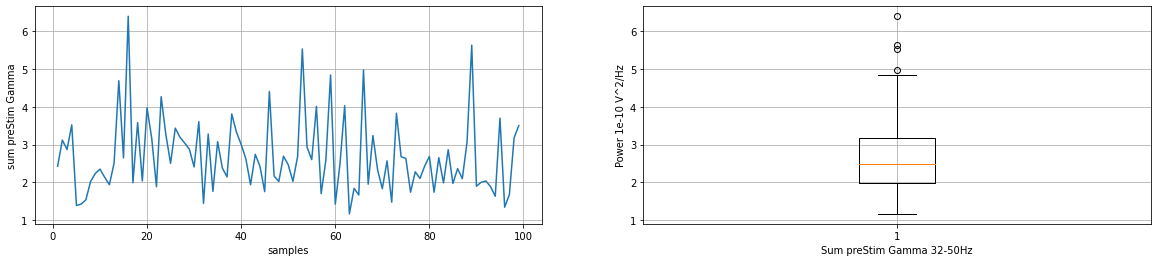

In [9]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,2,1)
plt.plot(np.arange(1, n_used_samples), U1_X0_sel['sum_preStim_gamma']);
plt.xlabel("samples")
plt.ylabel("sum preStim Gamma")
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.boxplot(U1_X0_sel['sum_preStim_gamma']);
plt.xlabel("Sum preStim Gamma 32-50Hz")
plt.ylabel("Power 1e-10 V^2/Hz")
plt.grid(visible=True)

plt.show();

In [10]:
hill_sum_preStim_gamma = np.empty((n_acquisition))
min_sum_preStim_gamma = np.min(X0_psd['sum_preStim_gamma'])
first_quartile_sum_preStim_gamma = np.quantile(X0_psd['sum_preStim_gamma'], 0.25)
third_quartile_sum_preStim_gamma = np.quantile(X0_psd['sum_preStim_gamma'], 0.75)
# max_sum_preStim_gamma = np.max(X0_psd['sum_preStim_gamma'])
print("min preStimGamma is: \n", min_sum_preStim_gamma, " \n 3rd Quartile preStimGamma is:", 
      third_quartile_sum_preStim_gamma)
half_n_samples = int(n_acquisition/2)
step_size = np.round((third_quartile_sum_preStim_gamma-first_quartile_sum_preStim_gamma)/half_n_samples,6)
# hill_sum_preStim_gamma[0:half_n_samples] = np.arange(min_sum_preStim_gamma, third_quartile_sum_preStim_gamma, step_size)
# hill_sum_preStim_gamma[half_n_samples:n_acquisition] = np.arange(third_quartile_sum_preStim_gamma,
#                                                                      min_sum_preStim_gamma, -step_size)
hill_sum_preStim_gamma[0:half_n_samples] = np.linspace(first_quartile_sum_preStim_gamma, third_quartile_sum_preStim_gamma, half_n_samples)
hill_sum_preStim_gamma[half_n_samples:n_acquisition] = np.flip(np.linspace(first_quartile_sum_preStim_gamma, third_quartile_sum_preStim_gamma, half_n_samples))

print(hill_sum_preStim_gamma[0:3], np.shape(hill_sum_preStim_gamma))

min preStimGamma is: 
 0.8137995193089469  
 3rd Quartile preStimGamma is: 2.5742740008887974
[1.52262311 1.54408538 1.56554764] (100,)


In [11]:
X0_psd_sampled = X0_psd.iloc[1:n_used_samples]
display(X0_psd_sampled['sum_preStim_gamma'])
display(U1_X0_sel['sum_preStim_gamma'])

1     2.425945
2     3.117866
3     2.868627
4     3.521665
5     1.384478
        ...   
95    3.700448
96    1.337936
97    1.672055
98    3.179625
99    3.502282
Name: sum_preStim_gamma, Length: 99, dtype: float64

1     2.425945
2     3.117866
3     2.868627
4     3.521665
5     1.384478
        ...   
95    3.700448
96    1.337936
97    1.672055
98    3.179625
99    3.502282
Name: sum_preStim_gamma, Length: 99, dtype: float64

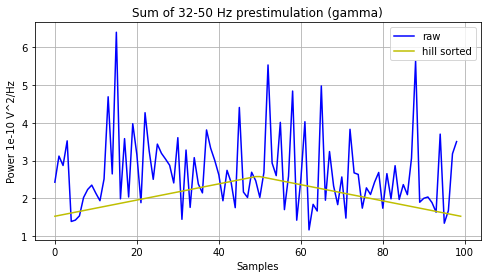

In [12]:
fig = plt.figure(figsize=(8,4));
# plt.plot(np.arange(0, n_used_samples), X0_psd_sampled['sum_preStim_gamma'], color='g');
plt.plot(np.arange(0, n_acquisition-1), U1_X0_sel['sum_preStim_gamma'][0:n_acquisition], color='b');

plt.plot(np.arange(0, n_acquisition), hill_sum_preStim_gamma, color='y');
plt.xlabel("Samples")
plt.ylabel("Power 1e-10 V^2/Hz")
plt.legend(['raw', 'hill sorted'])
plt.title("Sum of 32-50 Hz prestimulation (gamma)")
plt.grid(visible=True)

In [13]:
print('freq, amplitude and preStim gamma used are: \n', U1_X0_sel[0:4])

freq, amplitude and preStim gamma used are: 
    Stim_1  Stim_2  sum_preStim_gamma
1      42      40           2.425945
2      35      30           3.117866
3      23      50           2.868627
4      42      50           3.521665


In [14]:
print(np.shape(U1_X0_sel))

(99, 3)


## 1.2 First BaO Model is trained on all of the dataset

In [15]:
# ker_RBF = GPy.kern.RBF(input_dim=n_all_parameters, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)
ker_BaO = GPy.kern.Matern52(input_dim=n_all_parameters, variance=400., lengthscale=[10.,80.,1.],ARD=True) + GPy.kern.White(2)

In [16]:
slice_dim = 1
ylabel='Predicted Gamma'

#### 1.2.1: The first model uses sum_preStim_gamma.

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x22a6f1c2e50>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x22a6f1c2f70>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s10  0007   3.002775e+02   1.799638e-01 
    00s19  0014   2.981305e+02   2.082204e-02 
    00s53  0057   2.972559e+02   2.373254e-11 
Runtime:     00s53
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x22a73253d30>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x22a7323f970>]}

(1, 1)
(1, 50)
(1, 100)


{'dataplot': [<matplotlib.collections.PathCollection at 0x22a7341d370>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x22a73407fa0>]}

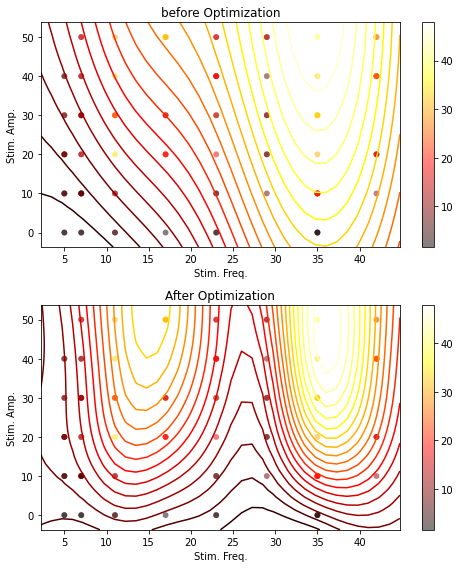

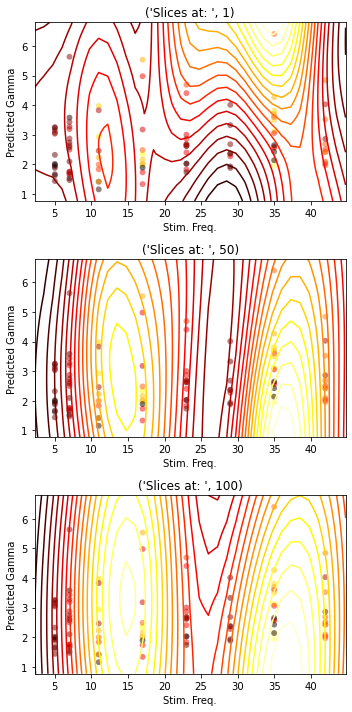

In [17]:
# x_BaO, y_BaO, trained_model_BaO = model.initialize_data_dr_sim(U1, X0_psd, X1, ker_BaO, slice_dim, ylabel)

# create simple GP model
trained_model_BaO = GPy.models.GPRegression(U1_X0_sel,X1_sel,ker_BaO)
figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
              title="before Optimization");
display(canvas);
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax);

# optimize and plot
trained_model_BaO.optimize(messages=True,max_f_eval = 1000);
canvas_optimized = trained_model_BaO.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                title='After Optimization');
display(canvas_optimized)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [1, 50, 100]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas_slices = trained_model_BaO.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas_slices);

15.808711076340295

15.965165983569989

15.808711076340295

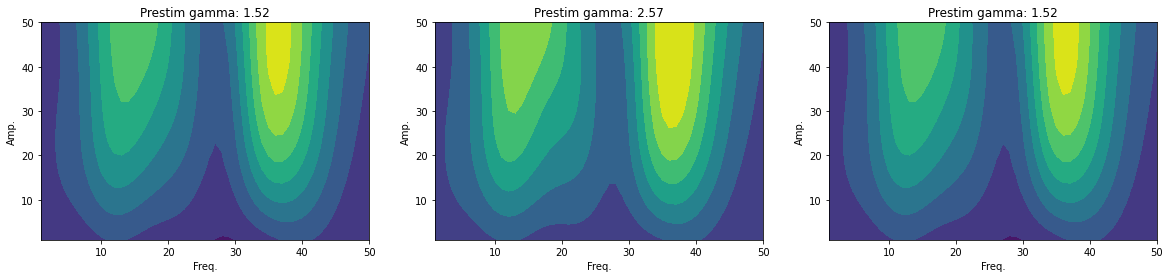

In [18]:
sim_optparam_test = np.full([len(hill_sum_preStim_gamma),2], np.nan)

#pts_surf = [0,24,49]
pts_surf = [0,50,99]

fig = plt.figure(figsize = (20,4))

X_grid1 = np.arange(1,51)
X_grid2 = np.arange(1,51)
X_grid_mesh = np.meshgrid(X_grid1, X_grid2)
X_grid = np.concatenate((np.asarray(X_grid_mesh[0]).reshape(-1,1), np.asarray(X_grid_mesh[1]).reshape(-1,1)),axis = 1)

counter = 1
for a in range(0, n_acquisition):
    
    # print("acquisition #: ", a)
    temp = np.full([len(X_grid),1], hill_sum_preStim_gamma[a])
    
    X_pred = np.concatenate((X_grid, temp), axis = 1)
    simY_BaO_AF = np.empty((1, n_samples))
    simMse_BaO_AF = np.empty((1, n_samples))
    simY_BaO_AF, simMse_BaO_AF= trained_model_BaO.predict(X_pred);
                             
    argMax_model = simY_BaO_AF.argmax()
    # sim_optparam_test[a,:] = np.append(testX[argMax_model],hill_sum_preStim_gamma[a:a+1], axis=0)
    sim_optparam_test[a,:] = X_grid[argMax_model]
    
    if a in pts_surf:
        #ax = fig.add_subplot(1,3,counter,projection='3d')
        ax = fig.add_subplot(1,3,counter)
        # data = pd.DataFrame(data={'x':X_pred[:,0], 'y':X_pred[:,1], 'z':np.squeeze(simY_BaO_AF)})
        # data = data.pivot(index='x', columns='y', values='z')
        # sns.heatmap(data)
        #ax.scatter(X_pred[:,0],X_pred[:,1],simY_BaO_AF)
        ax.contourf(X_grid1,X_grid2,np.reshape(simY_BaO_AF,(len(X_grid1),len(X_grid2))))
        plt.title(f"Prestim gamma: {'{0:.2f}'.format(hill_sum_preStim_gamma[a])}")
        plt.xlabel('Freq.')
        plt.ylabel('Amp.')
        counter = counter + 1
        
        display(np.mean(simY_BaO_AF))

plt.show()

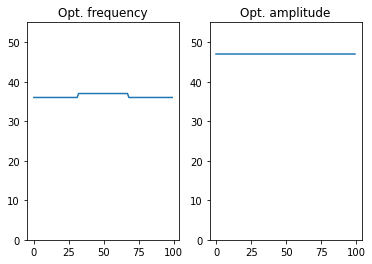

In [19]:
# display(sim_optparam_test)
plt.figure()
plt.subplot(1,2,1)
plt.plot(sim_optparam_test[:,0])
plt.title('Opt. frequency')
plt.ylim([0,55])
plt.subplot(1,2,2)
plt.plot(sim_optparam_test[:,1])
plt.title('Opt. amplitude')
plt.ylim([0,55])
plt.show()

## 1.3: Train the Static model on just the burn-in points, and then use the Acquisition function to pick the next freq/amp 

- The Static model does not use preStimGamma and brain state.
- Then get the suggested freq/amp/preStimGamma from the first model 
- Plot freq/amp/PostStimGamma after 50 interations of acquisition function

In [20]:
# applying data mask

U1_X0 = U1.join(X0_psd)

# U1_X0_sel = U1_X0[0:n_used_samples]
# X1_sel = X1[0:n_used_samples]

U1_X0_sel, X1_sel = model.apply_data_mask(U1_X0, X1, n_used_samples)
U1_sel = U1_X0_sel[['Stim_1','Stim_2']]
display(U1_sel)
display(X1_sel.shape)

,Stim_1,Stim_2
1,42,40
2,35,30
3,23,50
4,42,50
5,35,50
...,...,...
95,35,20
96,17,20
97,5,10
98,17,30


(99, 1)

In [21]:
# chose the first 10 for burn-in/initial training of the model
U1_init = U1_sel.loc[0:n_burn_in,:]
# X0_psd_init = X0_psd.loc[0:n_burn_in-1]
X1_init = X1_sel[0:n_burn_in,:]
print( '\n','freq and amplitude used are: \n', U1_init, np.shape(U1_init))
print('sum postStim gamma are: \n', X1_init, np.shape(X1_init))


 freq and amplitude used are: 
     Stim_1  Stim_2
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20
20      11      40 (20, 2)
sum postStim gamma are: 
 [[28.28259212]
 [35.3155382 ]
 [17.41537359]
 [26.71258011]
 [47.85447968]
 [ 6.13675736]
 [ 3.01429459]
 [28.70903269]
 [30.25154388]
 [36.50382584]
 [40.34110616]
 [ 8.1601432 ]
 [21.91015639]
 [22.44319194]
 [17.26180094]
 [25.97398224]
 [33.03514638]
 [ 1.87336865]
 [18.62013357]
 [33.03904107]] (20, 1)


In [22]:
# input_data
# U1_X0_init = U1_init.join(X0_psd_init)

In [23]:
print(type(U1_init),type(X1_init))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [24]:
ker_BaO_AF = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=400.,lengthscale=[10.,80.], ARD=True) + GPy.kern.White(2)
# GPy.kern.RBF(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

#### 1.3.1: initial training

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0007   6.883055e+01   1.017261e-03 
    00s15  0015   6.855457e+01   3.015503e-06 
    00s19  0020   6.855433e+01   4.800481e-05 
    00s30  0035   6.854357e+01   6.586212e-14 
Runtime:     00s30
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x22a6e94da30>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x22a6ea2afd0>]}

(1, 1)
(1, 50)
(1, 100)


{'dataplot': [<matplotlib.collections.PathCollection at 0x22a6ed1a1c0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x22a6ed1a550>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x22a6ed1a580>]}

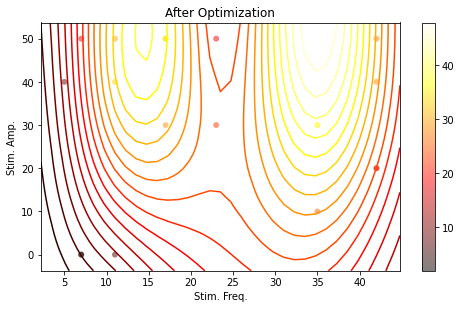

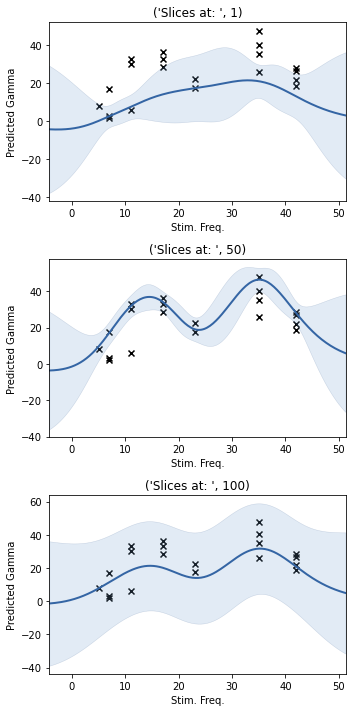

In [25]:
# x_BaO_AF, y_BaO_AF, trained_model_BaO_AF = model.initialize_data_dr_sim(U1_init, X0_psd_init, X1_init, ker_BaO_AF, slice_dim, ylabel)

trained_model_BaO_AF = GPy.models.GPRegression(U1_init,X1_init, ker_BaO_AF)
trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000);

figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_AF.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [1, 50, 100]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_AF.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

In [26]:
print(trained_model_BaO_AF.kern.Mat52.lengthscale.values)
print(trained_model_BaO_AF.kern.Mat52.variance.values[0])

[10.17045148 65.4575036 ]
437.1965362153913


#### 1.3.2: Use the acquisition function to guide the next freq to optimize at

In [27]:
rand_freq_1d = np.random.choice([5, 7, 11, 17, 23, 29, 35, 42], size=(50))
rand_freq_1d_sorted = np.sort(rand_freq_1d)
print(rand_freq_1d_sorted, np.shape(rand_freq_1d_sorted))
rand_amp_1d = np.random.choice([10, 20, 30, 40, 50], size=(50))
rand_amp_1d_sorted = np.sort(rand_amp_1d)
print(rand_amp_1d_sorted, np.shape(rand_amp_1d_sorted))
rand_time_1d = np.random.choice(np.arange(0,384),size=(50))
print(rand_time_1d, rand_time_1d.shape)
X_grid_mesh = np.meshgrid(rand_freq_1d_sorted, rand_amp_1d_sorted)
X_grid = np.concatenate((np.asarray(X_grid_mesh[0]).reshape(-1,1), np.asarray(X_grid_mesh[1]).reshape(-1,1)),axis = 1)

X_grid_mesh_t = np.meshgrid(rand_freq_1d_sorted, rand_amp_1d_sorted, rand_time_1d)
X_grid_t = np.concatenate((np.asarray(X_grid_mesh_t[0]).reshape(-1,1), np.asarray(X_grid_mesh_t[1]).reshape(-1,1), np.asarray(X_grid_mesh_t[2]).reshape(-1,1)),axis = 1)
print(np.shape(X_grid), X_grid_t.shape)

[ 5  5  5  5  5  5  7  7  7  7 11 11 11 11 11 11 11 11 11 11 17 17 17 17
 17 17 23 23 23 29 29 29 29 29 29 29 29 29 35 35 35 35 35 42 42 42 42 42
 42 42] (50,)
[10 10 10 10 10 10 20 20 20 20 20 20 20 20 20 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30 40 40 40 40 40 40 40 40 40 50 50 50 50 50 50 50 50 50
 50 50] (50,)
[358 341 278 204 346   9 217 168 181 366 328 171 293 264  48  99  83 336
 302 228 312 103 338  31  27  52 130 363 376 194  26 377 231 271 376 219
 315 300 160 106 289 249 105  70 183 199 332 126 314 154] (50,)
(2500, 2) (125000, 3)


In [28]:
# print(np.shape(rand_freq_1d_sorted), np.shape(rand_amp_1d_sorted))

# testX_BaO = np.array([rand_freq_1d_sorted, rand_amp_1d_sorted])
# print(np.shape(testX_BaO))
# testX = np.transpose(testX_BaO)
testX = X_grid
print(np.shape(testX))

(2500, 2)


In [29]:
def static_BaO_func(n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_AF, U1_init, 
                     X1_init, ker_BaO_AF):

    # a loop to optimize at every acquistion for 50 iteration and re-optimization, then plot before and after.
    ucb = np.empty((1, n_samples))
    ucb_sample = np.empty((n_acquisition, n_all_parameters))
    postStimGamma_predicted_from_simulation = np.empty((n_acquisition, 1))
    postStimGamma_predicted_from_simulation_static = np.empty((n_acquisition, 1))
    # print(np.shape(ucb))
    model_sample_static = np.empty((n_acquisition, n_all_parameters))

    nu = 0.1
    # print("nu set at: ", nu)
    static_lengthscale = np.empty((n_parameters_optimizing, n_acquisition))
    static_variance = np.empty((n_acquisition, 1))
    for a in range(0, n_acquisition):
        # print("acquisition #: ", a)
        simY_BaO_AF = np.empty((1, n_samples))
        simMse_BaO_AF = np.empty((1, n_samples))
        simY_BaO_AF, simMse_BaO_AF= trained_model_BaO_AF.predict(testX);

        argMax_model = simY_BaO_AF.argmax()
        model_sample_static[a,:] = np.append(testX[argMax_model],hill_sum_preStim_gamma[a:a+1], axis=0)
        model_sample_static_reshaped = np.reshape(model_sample_static[a,:], (1,n_all_parameters))
        # print("Simulation model prediction: ", model_sample_static_reshaped)

        ucb= model.acquisition_function(simY_BaO_AF, simMse_BaO_AF, nu, 1)
        max_ucb = np.max(ucb, axis=0)
        argMax_ucb = ucb.argmax()
        # find the values of argMax_ucb in the sample grid
        ucb_sample[a,:] = np.append(testX[argMax_ucb],hill_sum_preStim_gamma[a:a+1], axis=0)
        ucb_sample_reshaped = np.reshape(ucb_sample[a,:], (1,n_all_parameters))
        # print("Static model prediction: ", ucb_sample_reshaped)

        # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
        postStimGamma_predicted_from_simulation[a] = trained_model_BaO.posterior_samples_f(model_sample_static_reshaped, full_cov=True, size=1)[:,0,0]
        postStimGamma_predicted_from_simulation_static[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
        # simY_BaO, simMse_BaO =  trained_model_BaO.predict(ucb_sample_reshaped);

        # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
        next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample[a,0])], 'Stim_2':[int(ucb_sample[a,1])]})
        U1_init = pd.concat([U1_init, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)

        # Concatenate the first model predicted postStimGamma 
        next_postStimGamma = np.empty((1,1))
        next_postStimGamma[0,:] = [postStimGamma_predicted_from_simulation_static[a]]
        X1_init = np.append(X1_init, next_postStimGamma, axis=0)

        # trained_model_BaO_AF.add_observer()
        trained_model_BaO_AF = model.bayes_opt_update_state(U1_init, X1_init, ker_BaO_AF);
        static_lengthscale[:,a] = trained_model_BaO_AF.kern.Mat52.lengthscale.values
        static_variance[a] = trained_model_BaO_AF.kern.Mat52.variance.values[0]
        
    return trained_model_BaO_AF, model_sample_static, ucb_sample, postStimGamma_predicted_from_simulation, postStimGamma_predicted_from_simulation_static, static_lengthscale, static_variance

In [30]:
trained_model_BaO_AF, model_sample_static, ucb_sample, postStimGamma_predicted_from_simulation, postStimGamma_predicted_from_simulation_static, static_lengthscale, static_variance = static_BaO_func(
    n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_AF, U1_init, X1_init, ker_BaO_AF)

#### 1.3.3: Plot before and after optimization 

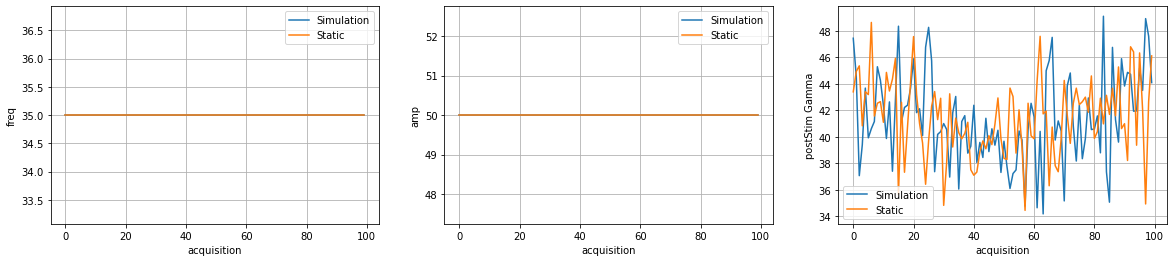

In [31]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,3,1)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(1,3,2)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(1,3,3)
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation, label=r"postStimGamma")
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation_static, label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)
plt.show();
# plot the model's max (freq, amp, postStim gamma) at each iteration

In [32]:
np.shape(static_lengthscale)

(2, 100)

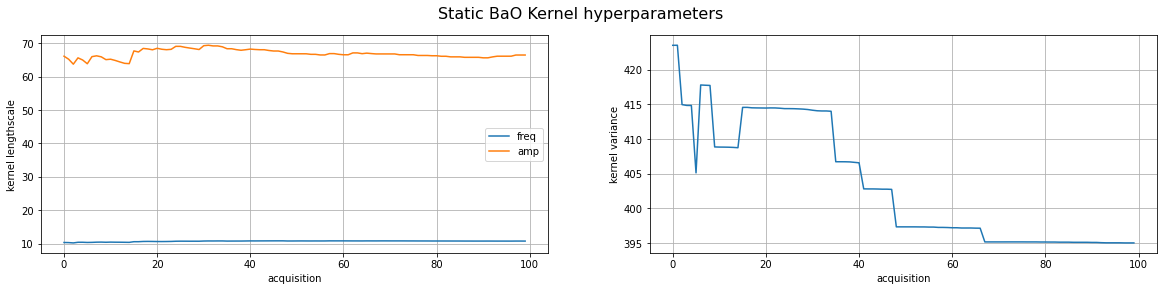

In [33]:
fig = plt.figure(figsize=(20,4));
fig.suptitle("Static BaO Kernel hyperparameters", fontsize=16)
plt.subplot(1,2,1)
plt.plot(np.arange(0,n_acquisition), static_lengthscale[0,:])
plt.plot(np.arange(0,n_acquisition),  static_lengthscale[1,:])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale")
plt.legend(["freq", "amp"])
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.plot(np.arange(0,n_acquisition), static_variance)
plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.grid(visible=True)

plt.show();

In [34]:
# print(ucb_sample)
print(ucb_sample[1:,0])
print(ucb_sample[1:,1])
# print(ucb_sample[1:,2])

[35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35.]
[50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50.]


In [35]:
print(postStimGamma_predicted_from_simulation_static[1:10])

[[44.92336612]
 [45.34802223]
 [40.82207533]
 [43.3908425 ]
 [43.18333814]
 [48.62354448]
 [41.56092052]
 [42.52768199]
 [42.64685752]]


### 1.4: Dynamic BaO

In [36]:
dynamic_model = state_dr_gp()

In [37]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1_dynamic, X1_dynamic, lower_bound, upper_bound, X0_psd_dynamic, N_trials = dynamic_model.gp_model(path)

In [38]:
U1_X0_dynamic = U1_dynamic.join(X0_psd_dynamic)
U1_X0_dynamic_sel, X1_dynamic_sel = dynamic_model.apply_data_mask(U1_X0_dynamic, X1_dynamic, n_used_samples)
U1_dynamic_sel = U1_X0_dynamic_sel[['Stim_1','Stim_2']]
display(U1_dynamic_sel)
display(X1_dynamic_sel.shape)

,Stim_1,Stim_2
1,42,40
2,35,30
3,23,50
4,42,50
5,35,50
...,...,...
95,35,20
96,17,20
97,5,10
98,17,30


(99, 1)

#### 1.4.1: We will not use preStimGamma, and instead we will train on most recent 20 samples so the model is not affected by brain state changes.

In [39]:
U1_init_dynamic = U1_dynamic_sel.loc[0:n_burn_in,:]
X1_init_dynamic = X1_dynamic_sel[0:n_burn_in,:]
# X0_psd_init_dynamic = X0_psd.loc[0:n_burn_in-1]

print('freq and amplitude used are: \n', U1_init_dynamic, np.shape(U1_init_dynamic))
# print('Sum preStim gamma are: \n', X0_psd_init_dynamic)
print('sum postStim gamma are: \n', X1_init_dynamic, np.shape(X1_init_dynamic))

freq and amplitude used are: 
     Stim_1  Stim_2
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20
20      11      40 (20, 2)
sum postStim gamma are: 
 [[28.28259212]
 [35.3155382 ]
 [17.41537359]
 [26.71258011]
 [47.85447968]
 [ 6.13675736]
 [ 3.01429459]
 [28.70903269]
 [30.25154388]
 [36.50382584]
 [40.34110616]
 [ 8.1601432 ]
 [21.91015639]
 [22.44319194]
 [17.26180094]
 [25.97398224]
 [33.03514638]
 [ 1.87336865]
 [18.62013357]
 [33.03904107]] (20, 1)


In [40]:
ker_BaO_dynamic = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=400., lengthscale=[10.,80.],ARD=True) + GPy.kern.White(2)
# GPy.kern.RBF(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [41]:
print(np.shape(U1_init_dynamic))
print(np.shape(X1_init_dynamic))
# print(np.shape(X0_psd_init_dynamic))

(20, 2)
(20, 1)


In [42]:
print(type(U1_init_dynamic),type(X1_init_dynamic))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


#### 1.4.2: Initial training of the Dynamic model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0003   6.937377e+01   3.967822e-01 
    00s07  0006   6.884338e+01   1.871197e-03 
    00s16  0013   6.856235e+01   2.135597e-03 
    00s18  0019   6.855447e+01   1.343792e-05 
    00s19  0020   6.855433e+01   4.800481e-05 
    00s35  0035   6.854357e+01   6.586212e-14 
Runtime:     00s35
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x22a73917a30>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x22a7394a850>]}

(1, 1)
(1, 50)
(1, 100)


{'dataplot': [<matplotlib.collections.PathCollection at 0x22a6f0defd0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x22a6f0de4c0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x22a6f0a4c10>]}

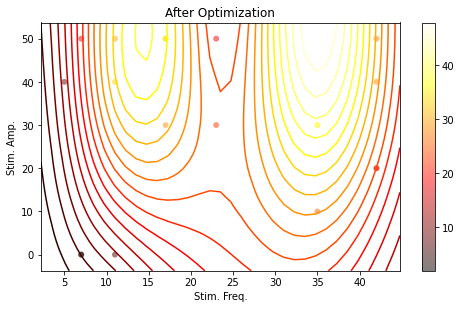

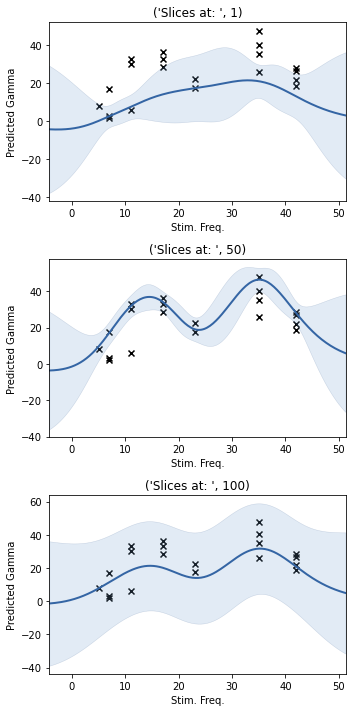

In [43]:
# Initialize a dynamic model:
# x_BaO_dynamic, y_BaO_dynamic, trained_model_BaO_Dynamic = dynamic_model.initialize_data_dr_sim(U1_init_dynamic, X0_psd_init_dynamic, X1_init_dynamic, 
#                                                                                                ker_BaO_dynamic, slice_dim, ylabel)
trained_model_BaO_Dynamic = GPy.models.GPRegression(U1_init_dynamic,X1_init_dynamic, ker_BaO_dynamic)
trained_model_BaO_Dynamic.optimize(messages=True,max_f_eval = 1000);

figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_Dynamic.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [1, 50, 100]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_Dynamic.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);
# x_BaO_dynamic, y_BaO_dynamic, trained_model_BaO_Dynamic = dynamic_model.initialize_data_dr_sim(U1_init_dynamic, X0_psd_init_dynamic, X1_init_dynamic, 
# ker_BaO, slice_dim, ylabel)

In [44]:
print(np.shape(testX))

(2500, 2)


#### 1.4.3: Using the acquisition function to guide the training of the Dynamic model

In [45]:
def dynamic_BaO_func(n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_Dynamic, U1_init_dynamic, 
                     X1_init_dynamic, ker_BaO_dynamic):
    
    ucb_dynamic = np.empty((1, n_samples))
    ucb_sample_dynamic = np.empty((n_acquisition, n_all_parameters))
    postStimGamma_predicted_from_simulation_d = np.empty((n_acquisition, 1))
    postStimGamma_predicted_from_simulation_dynamic = np.empty((n_acquisition, 1))
    # print(np.shape(ucb_dynamic))
    model_sample_dynamic = np.empty((n_acquisition, n_all_parameters))

    nu = 0.1
    # print("nu set at: ", nu)
    dynamic_lengthscale = np.empty((n_parameters_optimizing, n_acquisition))
    dynamic_variance = np.empty((n_acquisition, 1))    
    
    for a in range(0, n_acquisition):
        # print("acquisition #: ", a)
        simY_BaO_dynamic = np.empty((1, n_samples))
        simMse_BaO_dynamic = np.empty((1, n_samples))
        simY_BaO_dynamic, simMse_BaO_dynamic= trained_model_BaO_Dynamic.predict(testX);

        argMax_model = simY_BaO_dynamic.argmax()
        model_sample_dynamic[a,:] = np.append(testX[argMax_model],hill_sum_preStim_gamma[a:a+1], axis=0)
        model_sample_dynamic_reshaped = np.reshape(model_sample_dynamic[a,:], (1,n_all_parameters))
        # print("Simulation model prediction: ", model_sample_dynamic_reshaped)    

        ucb_dynamic= dynamic_model.acquisition_function(simY_BaO_dynamic, simMse_BaO_dynamic, nu, 1)
        max_ucb_dynamic = np.max(ucb_dynamic, axis=0)
        argMax_ucb_dynamic = ucb_dynamic.argmax()
        # find the values of argMax_ucb in the sample grid np.append(testX[argMax_ucb],np.zeros([1]), axis=0)
        ucb_sample_dynamic[a, :] = np.append(testX[argMax_ucb_dynamic],hill_sum_preStim_gamma[a:a+1], axis=0)
        ucb_sample_reshaped = np.reshape(ucb_sample_dynamic[a,:], (1,n_all_parameters))
        # print("Dynamic model prediction: ", ucb_sample_reshaped)
        # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
        postStimGamma_predicted_from_simulation_d[a] = trained_model_BaO.posterior_samples_f(model_sample_dynamic_reshaped, full_cov=True, size=1)[:,0,0]
        postStimGamma_predicted_from_simulation_dynamic[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
        # print(postStimGamma_predicted_from_simulation_dynamic[a])
        # simY_BaO_dynamic, simMse_BaO_dynamic =  trained_model_BaO_Dynamic.predict(ucb_sample_reshaped);

        # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
        next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample_dynamic[a,0])], 'Stim_2':[int(ucb_sample_dynamic[a,1])]})
        U1_init_dynamic = pd.concat([U1_init_dynamic, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)
        U1_init_dynamic_twenty = U1_init_dynamic.loc[a:a+int(n_samples_to_remember-1),:]

    #     # sum_preStim_gamma
    #     next_preStimGamma_dynamic = pd.DataFrame({'sum_preStim_gamma':[int(ucb_sample_dynamic[a,2])]})
    #     X0_psd_init_dynamic = pd.concat([X0_psd_init_dynamic, next_preStimGamma_dynamic], ignore_index=True, axis=0)
    #     X0_psd_init_dynamic_twenty = X0_psd_init_dynamic.loc[a:a+int(n_burn_in),:]

        # Concatenate the first model predicted postStimGamma 
        next_postStimGamma = np.empty((1,1))
        next_postStimGamma[0,:] = [postStimGamma_predicted_from_simulation_dynamic[a]]
        X1_init_dynamic = np.append(X1_init_dynamic, next_postStimGamma, axis=0)
        # print("X1_init_dynamic shape is: ", np.shape(X1_init_dynamic))

        X1_init_dynamic_twenty = X1_init_dynamic[a:a+int(n_samples_to_remember),:]
        # print(np.shape(U1_init_dynamic_twenty),np.shape(X1_init_dynamic_twenty))
        # trained_model_BaO_AF.add_observer()
        # trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000)
        trained_model_BaO_Dynamic = dynamic_model.bayes_opt_update_state(U1_init_dynamic_twenty, X1_init_dynamic_twenty, ker_BaO_dynamic)
        dynamic_lengthscale[:,a] = trained_model_BaO_Dynamic.kern.Mat52.lengthscale.values
        dynamic_variance[a] = trained_model_BaO_Dynamic.kern.Mat52.variance.values[0]
        
    return trained_model_BaO_Dynamic, model_sample_dynamic, ucb_sample_dynamic, postStimGamma_predicted_from_simulation_d, postStimGamma_predicted_from_simulation_dynamic, dynamic_lengthscale, dynamic_variance

In [46]:
trained_model_BaO_Dynamic, model_sample_dynamic, ucb_sample_dynamic, postStimGamma_predicted_from_simulation_d, postStimGamma_predicted_from_simulation_dynamic, dynamic_lengthscale, dynamic_variance = dynamic_BaO_func(
    n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_Dynamic, U1_init_dynamic, X1_init_dynamic, ker_BaO_dynamic)

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:166: RuntimeWarning:overflow encountered in true_divide


In [47]:
# testX[argMax_ucb_dynamic]
print(np.shape(dynamic_lengthscale))

(2, 100)


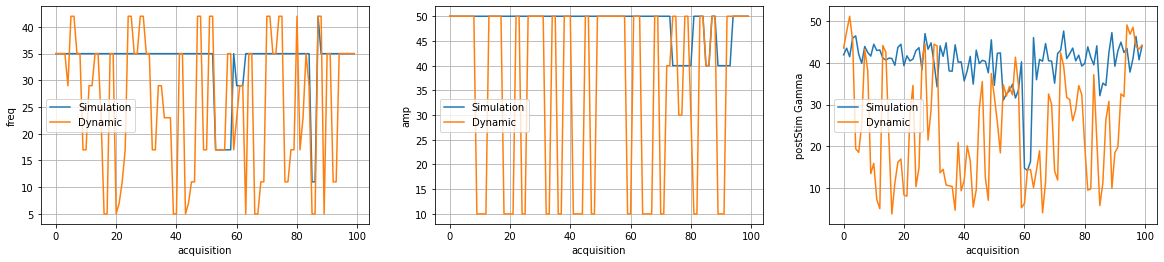

In [48]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,3,1)
plt.plot(np.arange(0,n_acquisition), model_sample_dynamic[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample_dynamic[:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)

plt.subplot(1,3,2)
plt.plot(np.arange(0,n_acquisition), model_sample_dynamic[0:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample_dynamic[0:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)

plt.subplot(1,3,3)
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation_d, label=r"postStimGamma")
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation_dynamic, label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)
plt.show()

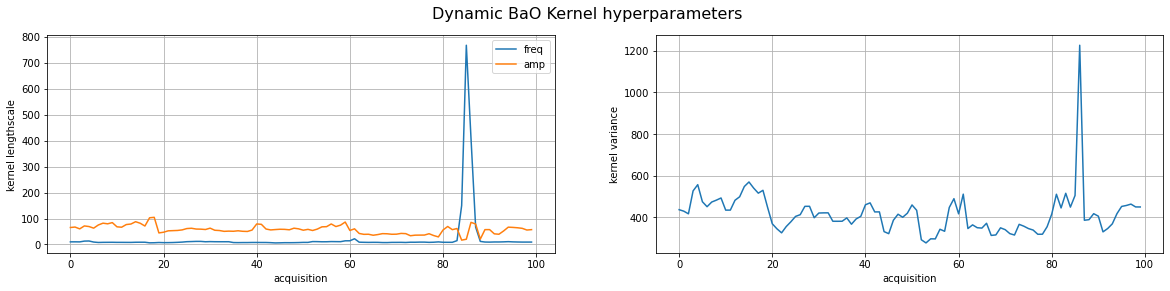

In [49]:
fig = plt.figure(figsize=(20,4));
fig.suptitle("Dynamic BaO Kernel hyperparameters", fontsize=16)
plt.subplot(1,2,1)
plt.plot(np.arange(0,n_acquisition), dynamic_lengthscale[0,:])
plt.plot(np.arange(0,n_acquisition),  dynamic_lengthscale[1,:])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale")
plt.legend(["freq", "amp"])
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.plot(np.arange(0,n_acquisition), dynamic_variance)
plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.grid(visible=True)

plt.show();

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x22a6f3b2e20>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x22a6f3948b0>]}

(1, 1)
(1, 50)
(1, 100)


{'dataplot': [<matplotlib.collections.PathCollection at 0x22a73cb2730>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x22a73cb2c70>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x22a73cb2ca0>]}

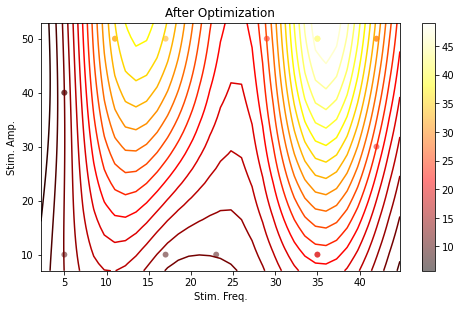

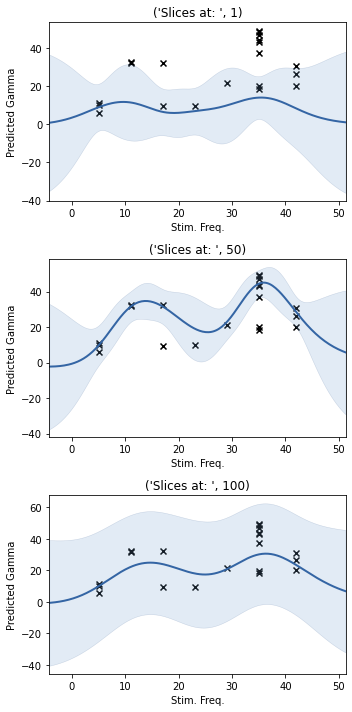

In [50]:
figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_Dynamic.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [1, 50, 100]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_Dynamic.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

### 1.5: Adaptive BaO

In [51]:
adaptive_model = state_dr_gp()

In [52]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1_adaptive, X1_adaptive, lower_bound, upper_bound, X0_psd_adaptive, N_trials = adaptive_model.gp_model(path)

In [53]:
U1_X0_adaptive = U1_adaptive.join(X0_psd_adaptive)
U1_X0_adaptive_sel, X1_adaptive_sel = adaptive_model.apply_data_mask(U1_X0_adaptive, X1_adaptive, n_used_samples)
U1_adaptive_sel = U1_X0_adaptive_sel[['Stim_1','Stim_2']]

In [54]:
time = np.arange(1, n_acquisition)
print(time.shape)
U1_adaptive_sel['time'] = time
print(U1_adaptive_sel.shape)
U1_adaptive_sel

(99,)
(99, 3)


,Stim_1,Stim_2,time
1,42,40,1
2,35,30,2
3,23,50,3
4,42,50,4
5,35,50,5
...,...,...,...
95,35,20,95
96,17,20,96
97,5,10,97
98,17,30,98


In [55]:
U1_init_adaptive = U1_adaptive_sel.loc[0:n_burn_in,:]
X1_init_adaptive = X1_adaptive_sel[0:n_burn_in,:]


In [56]:
print(np.shape(U1_init_adaptive))
print(np.shape(X1_init_adaptive))


(20, 3)
(20, 1)


In [57]:
ker_BaO_adaptive = GPy.kern.Matern52(input_dim=3, variance=400., lengthscale=[10.,80.,500.],ARD=True) + GPy.kern.White(3)

#### 1.5.1: Initial Training of the Adaptive Model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0006   6.884833e+01   1.700417e-03 
    00s16  0016   6.857081e+01   3.932430e-07 
    00s19  0020   6.857062e+01   4.509446e-05 
    00s30  0036   6.856078e+01   5.914442e-09 
Runtime:     00s30
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x22a73db1be0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x22a73da9730>]}

(1, 1)
(1, 50)
(1, 100)


{'dataplot': [<matplotlib.collections.PathCollection at 0x22a73952430>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x22a7392d610>]}

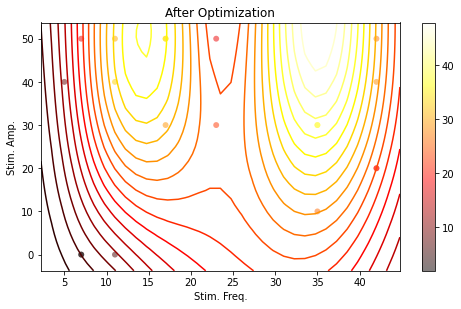

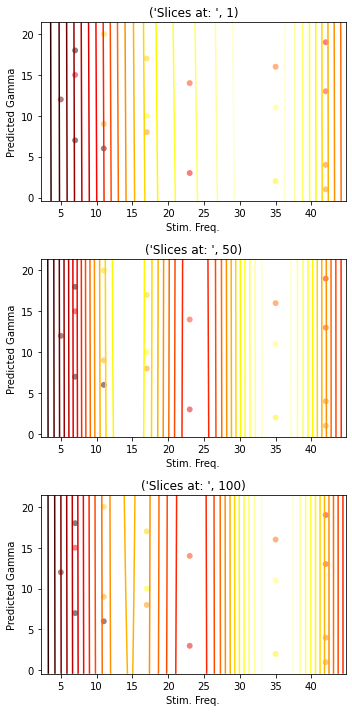

In [58]:
# Initialize the adaptive model:

trained_model_BaO_adaptive = GPy.models.GPRegression(U1_init_adaptive,X1_init_adaptive, ker_BaO_adaptive)
trained_model_BaO_adaptive.optimize(messages=True,max_f_eval = 1000);

figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_adaptive.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [1, 50, 100]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_adaptive.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

#### 1.5.2: Using the acquisition function to guide the training of the Adaptive model

In [59]:
# making a testX with time
testX_t=X_grid_t
testX_t.shape
print(n_all_parameters)
n_all_parameters_t = 4
print(n_all_parameters_t)
n_parameters_optimizing_t = 3

3
4


In [60]:
def adaptive_BaO_func(n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_adaptive, U1_init_adaptive, 
                     X1_init_adaptive, ker_BaO_adaptive):
    
    ucb_adaptive = np.empty((1, n_samples))
    ucb_sample_adaptive = np.empty((n_acquisition, n_all_parameters))
    postStimGamma_predicted_from_simulation_a = np.empty((n_acquisition, 1))
    postStimGamma_predicted_from_simulation_adaptive = np.empty((n_acquisition, 1))
    model_sample_adaptive = np.empty((n_acquisition, n_all_parameters))

    nu = 0.1
    # print("nu set at: ", nu)
    adaptive_lengthscale = np.empty((n_parameters_optimizing_t, n_acquisition))
    adaptive_variance = np.empty((n_acquisition, 1))    
    
    for a in range(0, n_acquisition):
        # print("acquisition #: ", a)
        simY_BaO_adaptive = np.empty((1, n_samples))
        simMse_BaO_adaptive = np.empty((1, n_samples))
        simY_BaO_adaptive, simMse_BaO_adaptive = trained_model_BaO_adaptive.predict(testX);

        argMax_model = simY_BaO_adaptive.argmax()
        model_sample_adaptive[a,:] = np.append(testX[argMax_model],hill_sum_preStim_gamma[a:a+1], axis=0)
        model_sample_adaptive_reshaped = np.reshape(model_sample_adaptive[a,:], (1,n_all_parameters))    

        ucb_adaptive = adaptive_model.acquisition_function(simY_BaO_adaptive, simMse_BaO_adaptive, nu, 1)
        max_ucb_adaptive = np.max(ucb_adaptive, axis=0)
        argMax_ucb_adaptive = ucb_adaptive.argmax()
        # find the values of argMax_ucb in the sample grid np.append(testX[argMax_ucb],np.zeros([1]), axis=0)
        ucb_sample_adaptive[a, :] = np.append(testX[argMax_ucb_adaptive],hill_sum_preStim_gamma[a:a+1], axis=0)
        ucb_sample_reshaped = np.reshape(ucb_sample_adaptive[a,:], (1,n_all_parameters))
     
        # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
        postStimGamma_predicted_from_simulation_a[a] = trained_model_BaO.posterior_samples_f(model_sample_adaptive_reshaped, full_cov=True, size=1)[:,0,0]
        postStimGamma_predicted_from_simulation_adaptive[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]

        # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
        next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample_adaptive[a,0])], 'Stim_2':[int(ucb_sample_adaptive[a,1])], 'time':[int(ucb_sample_adaptive[a,2])]})
        U1_init_adaptive = pd.concat([U1_init_adaptive, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2','time'], axis=0)
        # U1_init_adaptive_twenty = U1_init_adaptive.loc[a:a+int(n_samples_to_remember-1),:]

        # Concatenate the first model predicted postStimGamma 
        next_postStimGamma = np.empty((1,1))
        next_postStimGamma[0,:] = [postStimGamma_predicted_from_simulation_adaptive[a]]
        X1_init_adaptive = np.append(X1_init_adaptive, next_postStimGamma, axis=0)

        # X1_init_adaptive_twenty = X1_init_adaptive[a:a+int(n_samples_to_remember),:]
        trained_model_BaO_adaptive = adaptive_model.bayes_opt_update_state(U1_init_adaptive, X1_init_adaptive, ker_BaO_adaptive)
        adaptive_lengthscale[:,a] = trained_model_BaO_adaptive.kern.Mat52.lengthscale.values
        adaptive_variance[a] = trained_model_BaO_adaptive.kern.Mat52.variance.values[0]
        
    return trained_model_BaO_adaptive, model_sample_adaptive, ucb_sample_adaptive, postStimGamma_predicted_from_simulation_a, postStimGamma_predicted_from_simulation_adaptive, adaptive_lengthscale, adaptive_variance

In [61]:
trained_model_BaO_adaptive, model_sample_adaptive, ucb_sample_adaptive, postStimGamma_predicted_from_simulation_a, postStimGamma_predicted_from_simulation_adaptive, adaptive_lengthscale, adaptive_variance = adaptive_BaO_func(
    n_samples, n_all_parameters_t, n_acquisition, testX_t, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_adaptive, U1_init_adaptive, X1_init_adaptive, ker_BaO_adaptive)

### 1.6: comparing static and adaptive BaO

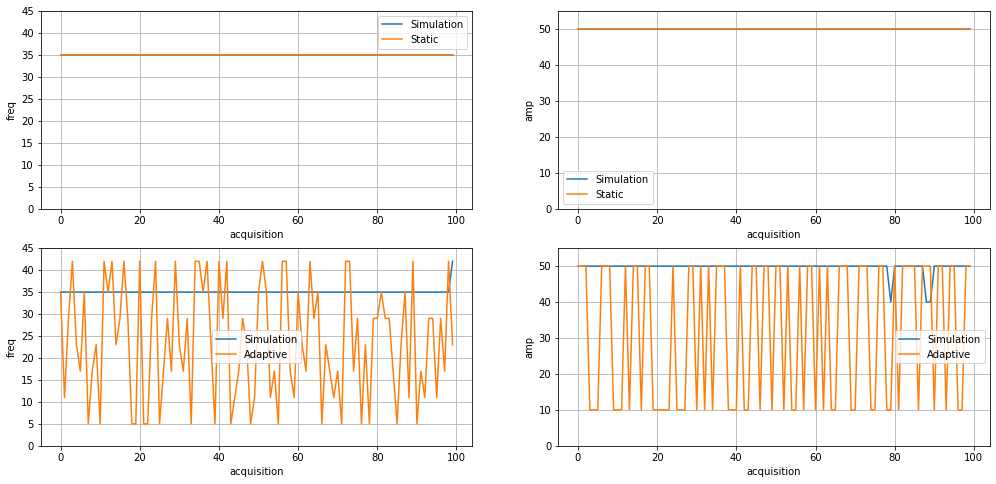

In [62]:
fig = plt.figure(figsize=(17,8));
fig.title = ("Simulation vs. Static/Dynamic BaO")
plt.subplot(2,2,1)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,0], label=r"frequency")
plt.ylim([0, 45])
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(2,2,2)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,1], label=r"amplitude")
plt.ylim([0, 55])
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(2,2,3)
plt.plot(np.arange(0,n_acquisition), model_sample_adaptive[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample_adaptive[:,0], label=r"frequency")
plt.ylim([0, 45])
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Adaptive"])
plt.grid(visible=True)

plt.subplot(2,2,4)
plt.plot(np.arange(0,n_acquisition), model_sample_adaptive[:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample_adaptive[:,1], label=r"amplitude")
plt.ylim([0, 55])
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Adaptive"])
plt.grid(visible=True)

plt.show()


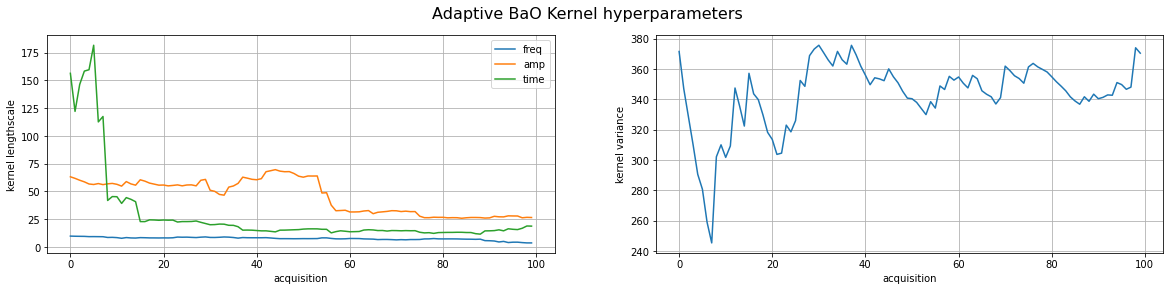

In [63]:
fig = plt.figure(figsize=(20,4));
fig.suptitle("Adaptive BaO Kernel hyperparameters", fontsize=16)
plt.subplot(1,2,1)
plt.plot(np.arange(0,n_acquisition), adaptive_lengthscale[0,:])
plt.plot(np.arange(0,n_acquisition), adaptive_lengthscale[1,:])
plt.plot(np.arange(0,n_acquisition), adaptive_lengthscale[2,:])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale")
plt.legend(["freq", "amp","time"])
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.plot(np.arange(0,n_acquisition), adaptive_variance)
plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.grid(visible=True)

plt.show();

### 1.7: Experiment Loop 

In [64]:
print(np.shape(model_sample_static))

(100, 3)


In [65]:
# Initialize variables:
# reshape variables
static_sample = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
dynamic_sample = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
adaptive_sample = np.empty((n_acquisition, n_all_parameters_t, n_exp_runs))
simulation_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))
static_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))

static_ucb = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
dynamic_ucb = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
adaptive_ucb = np.empty((n_acquisition, n_all_parameters_t, n_exp_runs))
simulation_postStimGamma_predicted_d = np.empty((n_acquisition, 1, n_exp_runs))
dynamic_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))
simulation_postStimGamma_predicted_a = np.empty((n_acquisition, 1, n_exp_runs))
adaptive_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))

static_lengthscale = np.empty((n_parameters_optimizing, n_acquisition, n_exp_runs))
static_variance = np.empty((n_acquisition, 1, n_exp_runs))
dynamic_lengthscale = np.empty((n_parameters_optimizing, n_acquisition, n_exp_runs))
dynamic_variance = np.empty((n_acquisition, 1, n_exp_runs))
adaptive_lengthscale = np.empty((n_parameters_optimizing_t, n_acquisition, n_exp_runs))
adaptive_variance = np.empty((n_acquisition, 1, n_exp_runs))

for e in range(0, n_exp_runs): #n_exp_runs
    print('Experiment run: ', e)
    
#     Initial training for satic: trained_model_BaO_AF, ker_BaO_AF
    U1_init = U1_sel.loc[0:n_burn_in,:]
    X1_init = X1_sel[0:n_burn_in,:]
    ker_BaO_AF = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=400., lengthscale=[10.,80.],ARD=True) + GPy.kern.White(2)
    trained_model_BaO_AF = GPy.models.GPRegression(U1_init,X1_init, ker_BaO_AF)
    trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000);
    
    U1_init_dynamic = U1_dynamic_sel.loc[0:n_burn_in,:]
    X1_init_dynamic = X1_dynamic_sel[0:n_burn_in,:]
    ker_BaO_dynamic = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=400., lengthscale=[10.,80.],ARD=True) + GPy.kern.White(2)
    trained_model_BaO_Dynamic = GPy.models.GPRegression(U1_init_dynamic,X1_init_dynamic, ker_BaO_dynamic)
    trained_model_BaO_Dynamic.optimize(messages=True,max_f_eval = 1000);
    
    U1_init_adaptive = U1_adaptive_sel.loc[0:n_burn_in,:]
    X1_init_adaptive = X1_adaptive_sel[0:n_burn_in,:]
    ker_BaO_adaptive = GPy.kern.Matern52(input_dim=n_parameters_optimizing_t, variance=400., lengthscale=[10.,80.,500.],ARD=True) + GPy.kern.White(3)
    trained_model_BaO_adaptive = GPy.models.GPRegression(U1_init_adaptive,X1_init_adaptive, ker_BaO_adaptive)
    trained_model_BaO_adaptive.optimize(messages=True,max_f_eval = 1000);
    
    _, static_sample[:,:,e], static_ucb[:,:,e], simulation_postStimGamma_predicted[:,:,e], static_postStimGamma_predicted[:,:,e], static_lengthscale[:,:,e], static_variance[:,0:1,e] = static_BaO_func(
        n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_AF, U1_init, X1_init, ker_BaO_AF)
    
    _, dynamic_sample[:,:,e], dynamic_ucb[:,:,e], simulation_postStimGamma_predicted_d[:,:,e], dynamic_postStimGamma_predicted[:,:,e], dynamic_lengthscale[:,:,e], dynamic_variance[:,0:1,e]  = dynamic_BaO_func(
        n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_Dynamic, U1_init_dynamic, X1_init_dynamic, ker_BaO_dynamic)
    
    _, adaptive_sample[:,:,e], adaptive_ucb[:,:,e], simulation_postStimGamma_predicted_a[:,:,e], adaptive_postStimGamma_predicted[:,:,e], adaptive_lengthscale[:,:,e], adaptive_variance[:,0:1,e]  = adaptive_BaO_func(
        n_samples, n_all_parameters_t, n_acquisition, testX_t, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_adaptive, U1_init_adaptive, X1_init_adaptive, ker_BaO_adaptive)
        
    print('end of run. \n ----------------------------------------')

Experiment run:  0
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0010   6.872195e+01   1.138759e-02 
    00s09  0018   6.855453e+01   3.491322e-06 
    00s14  0030   6.854358e+01   1.291708e-07 
    00s15  0035   6.854357e+01   6.586212e-14 
Runtime:     00s15
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0003   6.937377e+01   3.967822e-01 
    00s02  0006   6.884338e+01   1.871197e-03 
    00s06  0013   6.856235e+01   2.135597e-03 
    00s07  0016   6.855456e+01   4.393550e-07 
    00s18  0032   6.854357e+01   2.253991e-07 
    00s20  0035   6.854357e+01   6.586212e-14 
Runtime:     00s20
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   6.935369e+01   3.679006e-01 
    00s05  0011   6.868455e+01   2.719175e-02 
    00s06  0015   6.857082e+01   2.2226

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add


end of run. 
 ----------------------------------------
Experiment run:  4
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0004   6.901178e+01   7.908136e-02 
    00s02  0008   6.881616e+01   2.032247e-03 
    00s06  0017   6.855455e+01   5.086837e-07 
    00s10  0028   6.854371e+01   3.251277e-05 
    00s12  0034   6.854357e+01   6.586212e-14 
    00s12  0035   6.854357e+01   6.586212e-14 
Runtime:     00s12
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0004   6.901178e+01   7.908136e-02 
    00s05  0014   6.855526e+01   2.186626e-04 
    00s12  0028   6.854371e+01   3.251277e-05 
    00s16  0034   6.854357e+01   6.586212e-14 
    00s16  0035   6.854357e+01   6.586212e-14 
Runtime:     00s16
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0006   6.884833e+01 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


end of run. 
 ----------------------------------------
Experiment run:  18
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0002   7.023812e+01   1.774239e+00 
    00s10  0010   6.872195e+01   1.138759e-02 
    00s13  0013   6.856235e+01   2.135597e-03 
    00s19  0018   6.855453e+01   3.491322e-06 
    00s34  0035   6.854357e+01   6.586212e-14 
Runtime:     00s34
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0004   6.901178e+01   7.908136e-02 
    00s14  0012   6.861868e+01   1.467317e-02 
    00s18  0015   6.855457e+01   3.015503e-06 
    00s19  0017   6.855455e+01   5.086837e-07 
    00s33  0035   6.854357e+01   6.586212e-14 
Runtime:     00s33
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0003   6.935369e+01   3.679006e-01 
    00s06  0007   6.883626e+01

##### 1.7.1: plots for Std Dev and Mean

In [92]:
static_variance.shape
adaptive_lengthscale.shape

(3, 100, 30)

In [67]:
# calculate mean and std dev for the experiment runs
static_sample_mean = np.mean(static_sample,axis=2)
print(np.shape(static_sample_mean),'\n', static_sample_mean[0:3,:])
dynamic_sample_mean = np.mean(dynamic_sample, axis=2)
adaptive_sample_mean = np.mean(adaptive_sample, axis=2)

static_ucb_mean = np.mean(static_ucb, axis=2)
print(np.shape(static_ucb_mean),'\n', static_ucb_mean[0:3,:])
dynamic_ucb_mean = np.mean(dynamic_ucb, axis=2)
adaptive_ucb_mean = np.mean(dynamic_ucb, axis=2)

static_sample_std = np.std(static_sample, axis=2)
print(np.shape(static_sample_std),'\n', static_sample_std[0:3,:])
dynamic_sample_std = np.std(dynamic_sample, axis=2)
adaptive_sample_std = np.std(adaptive_sample, axis=2)

static_ucb_std = np.std(static_ucb, axis=2)
dynamic_ucb_std = np.std(dynamic_ucb, axis=2)
adaptive_ucb_std = np.std(dynamic_ucb, axis=2)

static_lengthscale_mean = np.mean(static_lengthscale, axis=2)
print(np.shape(static_lengthscale_mean),'\n', static_lengthscale_mean[0:3,0:3])
dynamic_lengthscale_mean = np.mean(dynamic_lengthscale, axis=2)
adaptive_lengthscale_mean = np.mean(adaptive_lengthscale, axis=2)

static_variance_mean = np.mean(static_variance, axis=2)
print(np.shape(static_variance_mean),'\n', static_variance_mean[0:3,0:3])
dynamic_variance_mean = np.mean(dynamic_variance, axis=2)
adaptive_variance_mean = np.mean(adaptive_variance, axis=2)

static_lengthscale_std = np.std(static_lengthscale, axis=2)
print(np.shape(static_lengthscale_std),'\n', static_lengthscale_std[0:3,0:3])
dynamic_lengthscale_std = np.std(dynamic_lengthscale, axis=2)
adaptive_lengthscale_std = np.std(adaptive_lengthscale, axis=2)

static_variance_std = np.std(static_variance, axis=2)
print(np.shape(static_variance_std),'\n', static_variance_std[0:3,0:3])
dynamic_variance_std = np.std(dynamic_variance, axis=2)
adaptive_variance_std = np.std(adaptive_variance, axis=2)

(100, 3) 
 [[35.         50.          1.52262311]
 [35.         50.          1.54408538]
 [35.         50.          1.56554764]]
(100, 3) 
 [[35.         50.          1.52262311]
 [34.4        50.          1.54408538]
 [34.6        50.          1.56554764]]
(100, 3) 
 [[0.00000000e+00 0.00000000e+00 2.22044605e-16]
 [0.00000000e+00 0.00000000e+00 4.44089210e-16]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
(2, 100) 
 [[10.37336414 10.22513799 10.16099774]
 [66.40445247 66.16669631 66.34490391]]
(100, 1) 
 [[425.91363365]
 [424.02767015]
 [419.75693095]]
(2, 100) 
 [[0.23943573 0.66101535 0.75065794]
 [1.65808393 1.92338549 2.41878038]]
(100, 1) 
 [[ 9.88330452]
 [10.83138047]
 [11.65459316]]


In [68]:
# Std Dev bar plots:
std_dev_ucb_df = pd.DataFrame({"Freq. (S)": static_ucb_std[:,0],
                               "Amp. (S)": static_ucb_std[:,1],
                                "Freq. (D)": dynamic_ucb_std[:,0],
                                "Amp. (D)": dynamic_ucb_std[:,1],
                                "Freq. (A)": adaptive_ucb_std[:,0],
                                "Amp. (A)": adaptive_ucb_std[:,1]})
display(std_dev_ucb_df.head())

,Freq. (S),Amp. (S),Freq. (D),Amp. (D),Freq. (A),Amp. (A)
0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,1.800000,0.0,0.000000,0.000000,0.000000,0.000000
2,1.496663,0.0,2.236068,0.000000,2.236068,0.000000
3,0.000000,0.0,1.077033,0.000000,1.077033,0.000000
4,0.000000,0.0,1.077033,13.597385,1.077033,13.597385


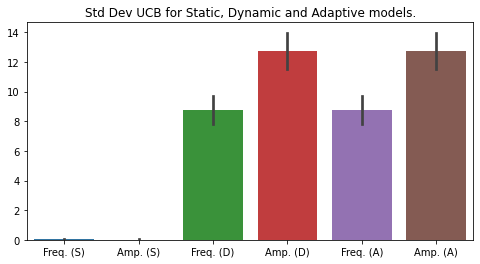

In [69]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=std_dev_ucb_df); 
plt.title("Std Dev UCB for Static, Dynamic and Adaptive models.");
plt.show();


In [70]:
std_dev_sim_df = pd.DataFrame({"Sim. Freq. (S)": static_sample_std[:,0],
                               "Sim. Amp. (S)": static_sample_std[:,1],
                               "Simu. Freq. (D)": dynamic_sample_std[:,0],
                               "Sim. Amp. (D)": dynamic_sample_std[:,1],
                               "Simu. Freq. (A)": adaptive_sample_std[:,0],
                               "Sim. Amp. (A)": adaptive_sample_std[:,1]})
display(std_dev_sim_df.head())

,Sim. Freq. (S),Sim. Amp. (S),Simu. Freq. (D),Sim. Amp. (D),Simu. Freq. (A),Sim. Amp. (A)
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


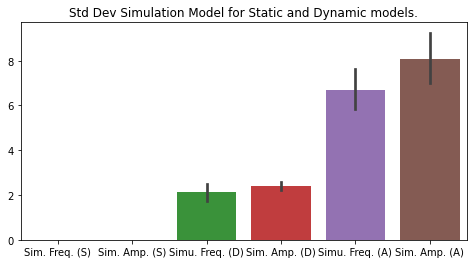

In [71]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=std_dev_sim_df); 
plt.title("Std Dev Simulation Model for Static and Dynamic models.");
plt.show();

In [72]:
# Mean UCB:
mean_ucb_df = pd.DataFrame({"Freq. (S)": static_ucb_mean[:,0],
                            "Amp. (S)": static_ucb_mean[:,1],
                            "Freq. (D)": dynamic_ucb_mean[:,0],
                            "Amp. (D)": dynamic_ucb_mean[:,1],
                            "Freq. (A)": adaptive_ucb_mean[:,0],
                            "Amp. (A)": adaptive_ucb_mean[:,1]})
display(mean_ucb_df.head())

,Freq. (S),Amp. (S),Freq. (D),Amp. (D),Freq. (A),Amp. (A)
0,35.0,50.0,35.0,50.000000,35.0,50.000000
1,34.4,50.0,35.0,50.000000,35.0,50.000000
2,34.6,50.0,34.0,50.000000,34.0,50.000000
3,35.0,50.0,34.8,50.000000,34.8,50.000000
4,35.0,50.0,29.2,44.666667,29.2,44.666667


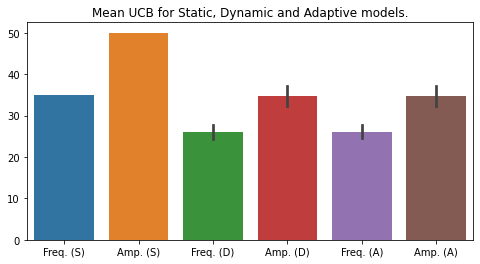

In [73]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=mean_ucb_df); 
plt.title("Mean UCB for Static, Dynamic and Adaptive models.");
plt.show();

In [74]:
# Mean Simulatino Model:
mean_sim_df = pd.DataFrame({"Freq. (S)": static_sample_mean[:,0],
                            "Amp. (S)": static_sample_mean[:,1],
                            "Freq. (D)": dynamic_sample_mean[:,0],
                            "Amp. (D)": dynamic_sample_mean[:,1],
                            "Freq. (A)": adaptive_sample_mean[:,0],
                            "Amp. (A)": adaptive_sample_mean[:,1]})
display(mean_sim_df.head())

,Freq. (S),Amp. (S),Freq. (D),Amp. (D),Freq. (A),Amp. (A)
0,35.0,50.0,35.0,50.0,35.0,50.0
1,35.0,50.0,35.0,50.0,35.0,50.0
2,35.0,50.0,35.0,50.0,35.0,50.0
3,35.0,50.0,35.0,50.0,35.0,50.0
4,35.0,50.0,35.0,50.0,35.0,50.0


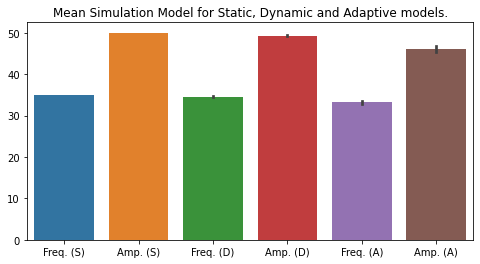

In [75]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=mean_sim_df); 
plt.title("Mean Simulation Model for Static, Dynamic and Adaptive models.");
plt.show();

##### 1.7.2: Acquisition plots

 C:\Users\sinad\AppData\Local\Temp\ipykernel_115484\1034292043.py:15: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x0000022A6F2CB100> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_115484\1034292043.py:15: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x0000022A6F2CBC10> has a label of '_Hidden' which cannot be automatically added to the legend.


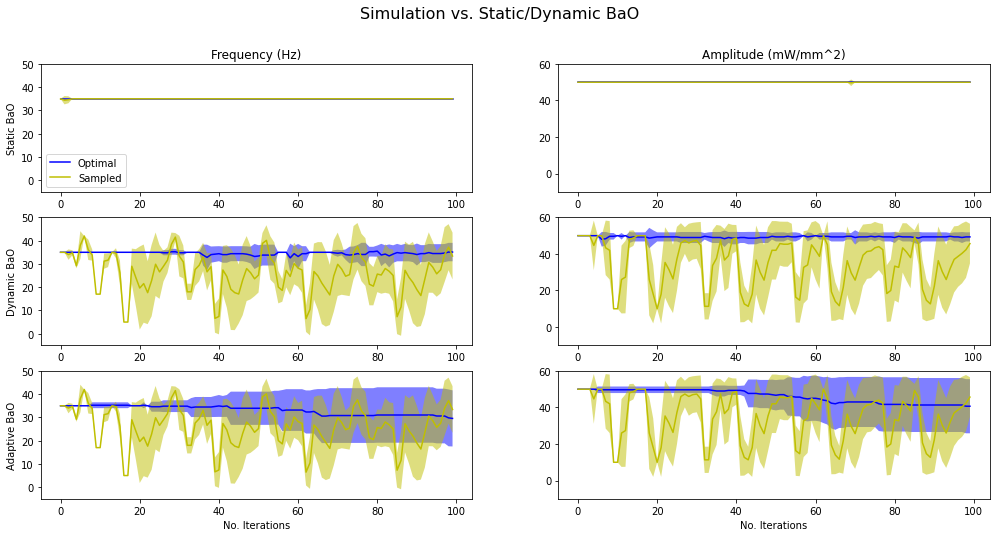

In [76]:
x_acquisitions = np.arange(0,n_acquisition)
fig = plt.figure(figsize=(17,8));
fig.suptitle("Simulation vs. Static/Dynamic BaO", fontsize=16)
plt.subplot(3,2,1)
plt.plot(x_acquisitions, static_sample_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_sample_mean[:,0]+static_sample_std[:,0],
                static_sample_mean[:,0]-static_sample_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, static_ucb_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, static_ucb_mean[:,0]+static_ucb_std[:,0],
                static_ucb_mean[:,0]-static_ucb_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-5, 50])
# plt.xlabel("No. Iterations")
plt.ylabel("Static BaO")
plt.title("Frequency (Hz)")
plt.legend(["Optimal", "_Hidden", "Sampled", "_Hidden"]);
# plt.grid(visible=True)

plt.subplot(3,2,2)
plt.plot(x_acquisitions, static_sample_mean[:,1], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, static_sample_mean[:,1]+static_sample_std[:,1],
                static_sample_mean[:,1]-static_sample_std[:,1], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, static_ucb_mean[:,1], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, static_ucb_mean[:,1]+static_ucb_std[:,1],
                static_ucb_mean[:,1]-static_ucb_std[:,1], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-10, 60])
# plt.xlabel("No. Iterations")
plt.title("Amplitude (mW/mm^2)")
# plt.legend(["Simulation", '_Hidden', "Static", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(3,2,3)
plt.plot(x_acquisitions, dynamic_sample_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, dynamic_sample_mean[:,0]+dynamic_sample_std[:,0],
                dynamic_sample_mean[:,0]-dynamic_sample_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_ucb_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, dynamic_ucb_mean[:,0]+dynamic_ucb_std[:,0],
                dynamic_ucb_mean[:,0]-dynamic_ucb_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-5, 50])
# plt.xlabel("No. Iterations")
plt.ylabel("Dynamic BaO")
# plt.legend(["Simulation", '_Hidden', "Dynamic", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(3,2,4)
plt.plot(x_acquisitions, dynamic_sample_mean[:,1], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, dynamic_sample_mean[:,1]+dynamic_sample_std[:,1],
                dynamic_sample_mean[:,1]-dynamic_sample_std[:,1], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_ucb_mean[:,1], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, dynamic_ucb_mean[:,1]+dynamic_ucb_std[:,1],
                dynamic_ucb_mean[:,1]-dynamic_ucb_std[:,1], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-10, 60])
# plt.xlabel("acquisition")
# plt.ylabel("amplitude")
# plt.legend(["Simulation", '_Hidden', "Dynamic", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(3,2,5)
plt.plot(x_acquisitions, adaptive_sample_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, adaptive_sample_mean[:,0]+adaptive_sample_std[:,0],
                adaptive_sample_mean[:,0]-adaptive_sample_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, adaptive_ucb_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, adaptive_ucb_mean[:,0]+adaptive_ucb_std[:,0],
                adaptive_ucb_mean[:,0]-adaptive_ucb_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-5, 50])
plt.xlabel("No. Iterations")
plt.ylabel("Adaptive BaO")
# plt.legend(["Simulation", '_Hidden', "Adaptive", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(3,2,6)
plt.plot(x_acquisitions, adaptive_sample_mean[:,1], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, adaptive_sample_mean[:,1]+adaptive_sample_std[:,1],
                adaptive_sample_mean[:,1]-adaptive_sample_std[:,1], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, adaptive_ucb_mean[:,1], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, adaptive_ucb_mean[:,1]+adaptive_ucb_std[:,1],
                adaptive_ucb_mean[:,1]-adaptive_ucb_std[:,1], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-10, 60])
plt.xlabel("No. Iterations")
# plt.ylabel("amplitude")
# plt.legend(["Simulation", '_Hidden', "Adaptive", '_Hidden']);
# plt.grid(visible=True)
plt.show();


In [77]:
static_variance_mean.shape

(100, 1)

 C:\Users\sinad\AppData\Local\Temp\ipykernel_115484\1732155615.py:14: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x0000022A6F10E670> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_115484\1732155615.py:14: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x0000022A6F10E940> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_115484\1732155615.py:27: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x0000022A73A7FD60> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_115484\1732155615.py:27: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x0000022A73959190> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_115

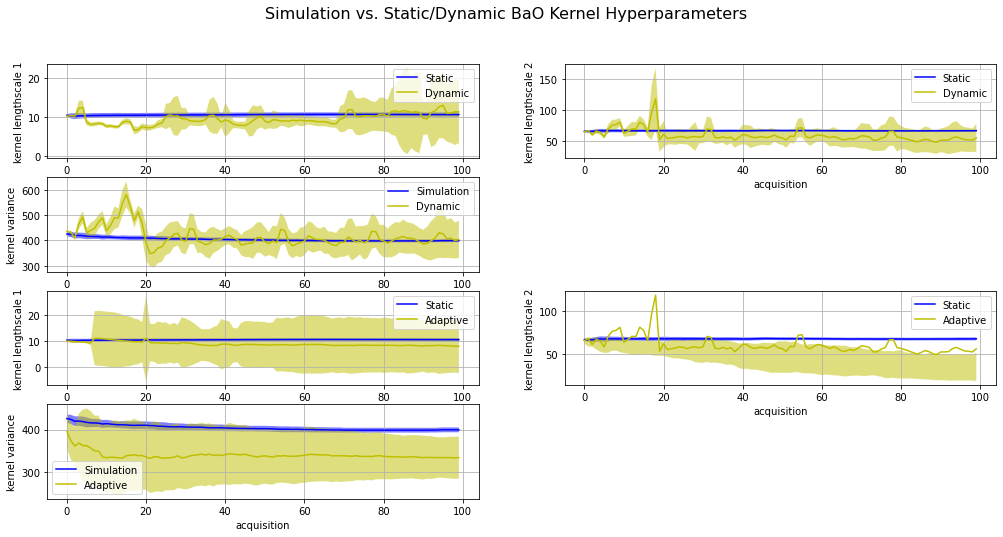

In [91]:
x_acquisitions = np.arange(0,n_acquisition)
fig = plt.figure(figsize=(17,8));
fig.suptitle("Simulation vs. Static/Dynamic BaO Kernel Hyperparameters", fontsize=16)
plt.subplot(4,2,1)
plt.plot(x_acquisitions, static_lengthscale_mean[0,:], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_lengthscale_mean[0,:]+static_lengthscale_std[0,:],
                static_lengthscale_mean[0,:]-static_lengthscale_std[0,:], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_lengthscale_mean[0,:], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, dynamic_lengthscale_mean[0,:]+dynamic_lengthscale_std[0,:],
                dynamic_lengthscale_mean[0,:]-dynamic_lengthscale_std[0,:], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
# plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale 1")
plt.legend(["Static", '_Hidden', "Dynamic", '_Hidden']);
plt.grid(visible=True)

plt.subplot(4,2,2)
plt.plot(x_acquisitions, static_lengthscale_mean[1,:], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, static_lengthscale_mean[1,:]+static_lengthscale_std[1,:],
                static_lengthscale_mean[1,:]-static_lengthscale_std[1,:], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_lengthscale_mean[1,:], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, dynamic_lengthscale_mean[1,:]+dynamic_lengthscale_std[1,:],
                dynamic_lengthscale_mean[1,:]-dynamic_lengthscale_std[1,:], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale 2")
plt.legend(["Static", '_Hidden', "Dynamic", '_Hidden']);
plt.grid(visible=True)

plt.subplot(4,2,3)
plt.plot(x_acquisitions, static_variance_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_variance_mean[:,0]+static_variance_std[:,0],
                static_variance_mean[:,0]-static_variance_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_variance_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, dynamic_variance_mean[:,0]+dynamic_variance_std[:,0],
                dynamic_variance_mean[:,0]-dynamic_variance_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
# plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.legend(["Simulation", '_Hidden', "Dynamic", '_Hidden']);
plt.grid(visible=True)

plt.subplot(4,2,5)
plt.plot(x_acquisitions, static_lengthscale_mean[0,:], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_lengthscale_mean[0,:]+static_lengthscale_std[0,:],
                static_lengthscale_mean[0,:]-static_lengthscale_std[0,:], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, adaptive_lengthscale_mean[0,:], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, adaptive_lengthscale_mean[0,:]+adaptive_lengthscale_std[0,:],
                adaptive_lengthscale_mean[0,:]-adaptive_lengthscale_std[0,:], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
# plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale 1")
plt.legend(["Static", '_Hidden', "Adaptive", '_Hidden']);
plt.grid(visible=True)

plt.subplot(4,2,6)
plt.plot(x_acquisitions, static_lengthscale_mean[1,:], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, static_lengthscale_mean[1,:]+static_lengthscale_std[1,:],
                static_lengthscale_mean[1,:]-static_lengthscale_std[1,:], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_lengthscale_mean[1,:], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, adaptive_lengthscale_mean[1,:]+adaptive_lengthscale_std[1,:],
                adaptive_lengthscale_mean[1,:]-adaptive_lengthscale_std[1,:], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale 2")
plt.legend(["Static", '_Hidden', "Adaptive", '_Hidden']);
plt.grid(visible=True)

plt.subplot(4,2,7)
plt.plot(x_acquisitions, static_variance_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_variance_mean[:,0]+static_variance_std[:,0],
                static_variance_mean[:,0]-static_variance_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, adaptive_variance_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, adaptive_variance_mean[:,0]+adaptive_variance_std[:,0],
                adaptive_variance_mean[:,0]-adaptive_variance_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.legend(["Simulation", '_Hidden', "Adaptive", '_Hidden']);
plt.grid(visible=True)

plt.show();

#### 1.7.3 Number of samples to converge

In [79]:
derivative_static_freq = np.gradient(static_ucb_mean[:,0])
idx_derivative_satic_freq = np.where(derivative_static_freq==0)
print("The derivative of Static Freq is: ", derivative_static_freq, "\n index where static freq plateaus: ", idx_derivative_satic_freq)

derivative_static_amp = np.gradient(static_ucb_mean[:,1])
idx_derivative_satic_amp = np.where(derivative_static_amp==0)
print("The derivative of Static Amp is: ", derivative_static_amp, "\n index where static freq plateaus: ", idx_derivative_satic_amp)

idx_plateau_static_freq = []
idx_plateau_static_amp = []
# print(np.size(idx_derivative_satic_freq), np.shape(idx_plateau_static_freq))
for p in range(0, n_acquisition):
    if derivative_static_freq[p:p+1]==0. :
        idx_plateau_static_freq = np.append(idx_plateau_static_freq,[p+1])
        # print(p, '\n ', idx_plateau_static_freq)
    if derivative_static_amp[p:p+1]==0. :
        idx_plateau_static_amp = np.append(idx_plateau_static_amp,[p+1])
        
print("The idx of first plateau for static model with length 2 sample for freq is: ", idx_plateau_static_freq[0]) 
print("The idx of first plateau static model with length 2 sample for amp is: ", idx_plateau_static_amp[0]) 

The derivative of Static Freq is:  [-0.6 -0.2  0.3  0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0. ] 
 index where static freq plateaus:  (array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,
       89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

In [80]:
derivative_dynamic_freq = np.gradient(dynamic_ucb_mean[:,0])
idx_derivative_dynamic_freq = np.where(derivative_dynamic_freq==0)
print("The derivative of dynamic Freq is: ", derivative_dynamic_freq, "\n index where dynamic freq plateaus: ", idx_derivative_dynamic_freq)

derivative_dynamic_amp = np.gradient(dynamic_ucb_mean[:,1])
idx_derivative_dynamic_amp = np.where(derivative_dynamic_amp==0)
print("The derivative of dynamic Amp is: ", derivative_dynamic_amp, "\n index where dynamic freq plateaus: ", idx_derivative_dynamic_amp)

idx_plateau_dynamic_freq = []
idx_plateau_dynamic_amp = []
# print(np.size(idx_derivative_satic_freq), np.shape(idx_plateau_static_freq))
for p in range(0, n_acquisition):
    if derivative_dynamic_freq[p:p+1]==0. :
        idx_plateau_dynamic_freq = np.append(idx_plateau_dynamic_freq,[p+1])
        # print(p, '\n ', idx_plateau_static_freq)
    if derivative_dynamic_amp[p:p+1]==0. :
        idx_plateau_dynamic_amp = np.append(idx_plateau_dynamic_amp,[p+1])
        
print("The idx of first plateau for dynamic model with length 2 sample for freq is: ", idx_plateau_dynamic_freq[0]) 
print("The idx of first plateau dynamic model with length 2 sample for amp is: ", idx_plateau_dynamic_amp[0]) 

The derivative of dynamic Freq is:  [  0.          -0.5         -0.1         -2.4          1.65
   6.4         -1.          -4.1         -9.55        -8.4
   7.1          7.3          1.9          1.5         -4.4
 -14.8        -10.6         12.           9.6         -4.68333333
  -1.33333333  -1.           0.65         6.11666667   1.86666667
  -0.43333333   2.51666667   4.71666667   4.96666667  -2.53333333
  -5.33333333  -7.68333333  -6.43333333   4.8          5.7
   2.7         -1.4         -2.1        -10.         -10.7
  10.4          8.6         -4.15        -3.48333333  -1.01666667
   2.73333333   5.46666667   1.55        -2.2         -0.5
   7.61666667   7.46666667  -3.15        -4.9         -6.25
  -5.86666667   3.58333333   3.           1.5          1.8
  -1.4        -10.86666667  -8.46666667  10.13333333   7.18333333
  -2.5         -2.81666667  -2.53333333   2.8          6.58333333
   1.5         -2.56666667  -1.2          5.06666667   6.08333333
  -1.03333333  -3.38333333  

In [81]:
idx_static_vs_dynamic_freq = idx_plateau_dynamic_freq[0] - idx_plateau_static_freq[0]
idx_static_vs_dynamic_amp = idx_plateau_dynamic_amp[0] - idx_plateau_static_amp[0]

print("the dynamic freq plateaus at sample %d after the static sample.", idx_static_vs_dynamic_freq)
print("the dynamic amp plateaus at sample %d after the static sample.", idx_static_vs_dynamic_amp)

the dynamic freq plateaus at sample %d after the static sample. -4.0
the dynamic amp plateaus at sample %d after the static sample. 0.0


In [82]:
print(np.shape(idx_plateau_static_freq),
     np.shape(idx_plateau_static_amp),
     np.shape(idx_plateau_dynamic_freq),
     np.shape(idx_plateau_dynamic_amp))

(96,) (98,) (1,) (7,)


<AxesSubplot:>

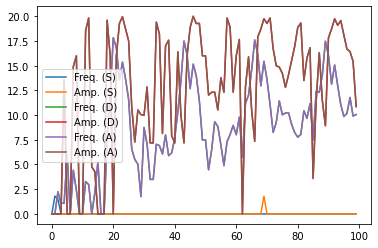

In [83]:
# number of samples to converge:
std_dev_ucb_df.plot.line()

In [84]:
std_dev_ucb_df.describe()

,Freq. (S),Amp. (S),Freq. (D),Amp. (D),Freq. (A),Amp. (A)
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.032967,0.017951,8.753470,12.776816,8.753470,12.776816
std,0.232929,0.179505,4.788827,6.397747,4.788827,6.397747
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,5.853215,9.713163,5.853215,9.713163
50%,0.000000,0.000000,8.902540,14.951708,8.902540,14.951708
75%,0.000000,0.000000,12.177079,17.953440,12.177079,17.953440
max,1.800000,1.795055,17.831589,20.000000,17.831589,20.000000


In [85]:
std_dev_static_freq_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Freq. (S)']<std_dev_ucb_df['Freq. (S)'].mean(),['Freq. (S)']].index
std_dev_static_amp_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Amp. (S)']<std_dev_ucb_df['Amp. (S)'].mean(),['Amp. (S)']].index

std_dev_dynamic_freq_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Freq. (D)']<std_dev_ucb_df['Freq. (D)'].mean(),['Freq. (D)']].index
std_dev_dynamic_amp_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Amp. (D)']<std_dev_ucb_df['Amp. (D)'].mean(),['Amp. (D)']].index
print('std_dev_static_freq_converge \n', std_dev_static_freq_converge)
print('std_dev_static_amp_converge \n', std_dev_static_amp_converge)
print('std_dev_dynamic_freq_converge \n', std_dev_dynamic_freq_converge)
print('std_dev_dynamic_amp_converge \n', std_dev_dynamic_amp_converge)

std_dev_static_freq_converge 
 Int64Index([ 0,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
            19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
            36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
            53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
            70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
            87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
           dtype='int64')
std_dev_static_amp_converge 
 Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
            86, 87, 88, 89, 90, 91, 92, 93, 94, 

In [86]:
print(np.shape(std_dev_static_freq_converge),
     np.shape(std_dev_static_amp_converge),
     np.shape(std_dev_dynamic_freq_converge),
     np.shape(std_dev_dynamic_amp_converge))

(98,) (99,) (49,) (40,)


#### 1.7.4: Comparing the Simulation with Static/Dynamic models using Normalized Mean-Squared-Error (NMSE).

$$NMSE(GP_{est}, GP_{sim})= \frac{||\mu_{est}(x)-\mu_{sim}(s)||_2^2}{||\mu_{sim}(x)||_2^2} $$

In [87]:
nmse_static_simulatinon_freq = np.square(np.subtract(static_ucb_mean[:,0], static_sample_mean[:, 0])).mean()/(np.square(static_sample_mean[:, 0])).mean()
nmse_static_simulatinon_freq = np.round(nmse_static_simulatinon_freq, 4)
print("nmse_static_simulatinon_freq: ", nmse_static_simulatinon_freq)
nmse_static_simulatinon_amp = np.square(np.subtract(static_ucb_mean[:,1], static_sample_mean[:, 1])).mean()/(np.square(static_sample_mean[:, 1])).mean()
nmse_static_simulatinon_amp = np.round(nmse_static_simulatinon_amp, 4)
print("nmse_static_simulatinon_amp: ", nmse_static_simulatinon_amp, '\n')

nmse_dynamic_simulatinon_freq = np.square(np.subtract(dynamic_ucb_mean[:,0], dynamic_sample_mean[:, 0])).mean()/(np.square(dynamic_sample_mean[:, 0])).mean()
nmse_dynamic_simulatinon_freq = np.round(nmse_dynamic_simulatinon_freq, 4)
print("nmse_dynamic_simulatinon_freq: ", nmse_dynamic_simulatinon_freq)
nmse_dynamic_simulatinon_amp = np.square(np.subtract(dynamic_ucb_mean[:,0], dynamic_sample_mean[:, 1])).mean()/(np.square(dynamic_sample_mean[:, 1])).mean()
nmse_dynamic_simulatinon_amp = np.round(nmse_dynamic_simulatinon_amp, 4)
print("nmse_dynamic_simulatinon_amp: ", nmse_dynamic_simulatinon_amp)

nmse_static_simulatinon_freq:  0.0
nmse_static_simulatinon_amp:  0.0 

nmse_dynamic_simulatinon_freq:  0.118
nmse_dynamic_simulatinon_amp:  0.2512


In [88]:
print(np.shape(static_ucb_std))

(100, 3)


In [89]:
# Post stimulation Gamma comparison plots

postStim_gamma_df = pd.DataFrame({"Sim. S": simulation_postStimGamma_predicted.flatten('C'),
                                 "Static": static_postStimGamma_predicted.flatten('C'),
                                 "Sim. D": simulation_postStimGamma_predicted_d.flatten('C'),
                                 "Dynamic": dynamic_postStimGamma_predicted.flatten('C'),
                                 "Sim. A": simulation_postStimGamma_predicted_a.flatten('C'),
                                 "Adaptive": adaptive_postStimGamma_predicted.flatten('C')})
postStim_gamma_df.head()

,Sim. S,Static,Sim. D,Dynamic,Sim. A,Adaptive
0,44.528615,40.319699,40.707542,46.970257,-18.787953,10.150512
1,45.453649,38.058107,45.331826,37.204894,-4.250234,7.287371
2,45.903005,44.575831,40.237623,44.144836,19.372120,-17.206058
3,40.984192,38.872165,38.531063,44.723681,-12.990808,-11.378670
4,41.927468,49.170611,39.824628,41.768000,-33.603942,-1.146219


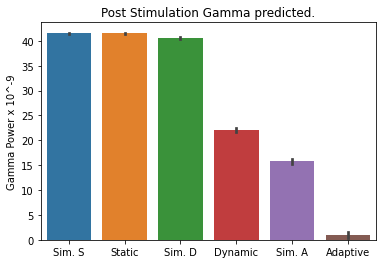

In [90]:
sns.barplot(data=postStim_gamma_df);
plt.ylabel("Gamma Power x 10^-9");
plt.title("Post Stimulation Gamma predicted.");
plt.show();

#### Next make the bayes_opt_update_state_dr()
function X_new_sample = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, t)

[Y_mean, ~, ~, Y_uncertainty] = objective_est.predict(input_space);

switch acquisition_function
    case 'PI'
        acq_value = predicted_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'EI'
        acq_value = expected_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'UCB'
        acq_value = upper_confidence_bound(Y_mean, Y_uncertainty, acq_params, t);
end

[~, max_idx] = max(acq_value);

X_new_sample = input_space(max_idx,:);

end